# 파이토치 RNN 분류 모델
- 코드 출처: https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-09-18 09:30:36--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.89.15, 13.225.89.26, 13.225.89.12, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.89.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2020-09-18 09:30:36 (30.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [2]:
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicodeToAscii('Ślusarski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/Greek.txt', 'data/names/Scottish.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [4]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def lettertoTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lettertoTensor('J'))
print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 신경망 생성

- 모델 생성 방법 참고 : https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

In [5]:
import torch.nn as nn

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = lettertoTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9382, -2.8615, -2.7971, -2.9330, -2.8446, -2.9270, -2.8866, -2.9825,
         -2.8893, -2.7738, -2.9478, -2.9446, -2.8880, -2.8627, -2.8947, -2.8680,
         -2.9146, -2.8965]], grad_fn=<LogSoftmaxBackward>)


In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9382, -2.8615, -2.7971, -2.9330, -2.8446, -2.9270, -2.8866, -2.9825,
         -2.8893, -2.7738, -2.9478, -2.9446, -2.8880, -2.8627, -2.8947, -2.8680,
         -2.9146, -2.8965]], grad_fn=<LogSoftmaxBackward>)


## 모델 학습
- 준비

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 9)


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("category: {}\t line: {}".format(category, line))

category: Dutch	 line: Andel
category: Chinese	 line: Jia
category: Greek	 line: Drivakis
category: Vietnamese	 line: Kim
category: Dutch	 line: Ryskamp
category: Greek	 line: Pezos
category: Dutch	 line: Lyon
category: French	 line: Favre
category: Japanese	 line: Shinko
category: Japanese	 line: Minatoya


## 손실함수

In [10]:
criterion = nn.NLLLoss()

## 모델 학습

In [11]:
learning_rate = 0.005

def train(Category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    return output, loss.item()

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'O' if guess == category else 'X (%s)' % category
        print("%d %d%% (%s) %.4f %s / %s %s" % (iter, iter/n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.6259 Lichman / Scottish X (Russian)
10000 10% (0m 12s) 3.4538 Koci / Vietnamese X (Czech)
15000 15% (0m 18s) 1.4782 Ahn / Vietnamese X (Korean)
20000 20% (0m 24s) 1.3460 Sai / Chinese X (Vietnamese)
25000 25% (0m 30s) 2.8586 Broz / Scottish X (Polish)
30000 30% (0m 36s) 2.1395 O'Brien / Scottish X (Irish)
35000 35% (0m 43s) 0.5641 Ferguson / Scottish O
40000 40% (0m 49s) 0.1535 Quyen / Vietnamese O
45000 45% (0m 55s) 2.9928 Nagel / Arabic X (Dutch)
50000 50% (1m 1s) 0.8420 Touma / Arabic O
55000 55% (1m 7s) 1.2163 D'cruz / Spanish X (Portuguese)
60000 60% (1m 13s) 3.6710 Jollenbeck / Dutch X (German)
65000 65% (1m 19s) 1.3805 Lorenz / Spanish X (German)
70000 70% (1m 26s) 1.4820 Lincoln / English O
75000 75% (1m 32s) 0.0580 O'Gorman / Irish O
80000 80% (1m 38s) 0.9744 Tojo / Japanese O
85000 85% (1m 44s) 1.6755 Allport / French X (English)
90000 90% (1m 50s) 1.7875 Stanek / Czech X (Polish)
95000 95% (1m 56s) 0.5912 Hayami / Japanese O
100000 100% (2m 2s) 1.9195 Black

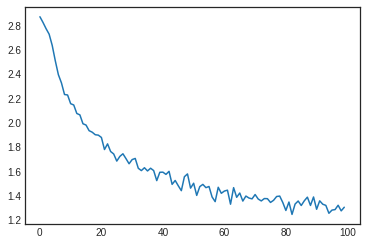

In [13]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.figure()
plt.plot(all_losses)
plt.show()

## 모델 테스트

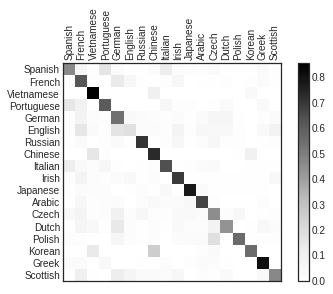

In [14]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 사용자 입력으로부터의 실행

In [21]:
def predict(input_line, n_predictions = 3):
    print("\n %s" % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions= []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("(%.2f) %s" % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict("Jackson")
predict("Bill")
predict("Devesky")
predict("Lee")
predict("Kim")
predict("Hyoungsun")


 Jackson
(-0.70) Scottish
(-1.50) English
(-2.01) Czech

 Bill
(-1.60) English
(-1.77) German
(-1.79) Irish

 Devesky
(-0.77) Czech
(-0.98) Russian
(-2.13) Polish

 Lee
(-0.52) Chinese
(-1.62) Vietnamese
(-2.81) French

 Kim
(-0.98) Chinese
(-1.04) Korean
(-2.11) Vietnamese

 Hyoungsun
(-0.45) Russian
(-1.94) Dutch
(-2.73) Czech
